In [8]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
# Hyper-parameters

learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomGrayscale(),
    # transforms.RandomPerspective(),
    transforms.ToTensor()]) #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

batch_size = 64

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl

Files already downloaded and verified
Files already downloaded and verified


In [21]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)
model = ResNet34().to(device)


cuda


In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dl), epochs=60)

In [24]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
oss_store_train =[]
loss_store_val = []
loss_store_train = []
acc_store=[]
epoches=60
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
        
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))
    scheduler.step()

Loss in epoch 0: 3.856
Got 1600 / 10000 with accuracy 16.00
Loss in epoch 1: 3.153
Got 3014 / 10000 with accuracy 30.14
Loss in epoch 2: 2.656
Got 3679 / 10000 with accuracy 36.79
Loss in epoch 3: 2.266
Got 4073 / 10000 with accuracy 40.73
Loss in epoch 4: 1.991
Got 4814 / 10000 with accuracy 48.14
Loss in epoch 5: 1.787
Got 5035 / 10000 with accuracy 50.35
Loss in epoch 6: 1.613
Got 5339 / 10000 with accuracy 53.39
Loss in epoch 7: 1.471
Got 5658 / 10000 with accuracy 56.58
Loss in epoch 8: 1.357
Got 5565 / 10000 with accuracy 55.65
Loss in epoch 9: 1.248
Got 5790 / 10000 with accuracy 57.90
Loss in epoch 10: 1.154
Got 5968 / 10000 with accuracy 59.68
Loss in epoch 11: 1.070
Got 6148 / 10000 with accuracy 61.48
Loss in epoch 12: 0.986
Got 6139 / 10000 with accuracy 61.39
Loss in epoch 13: 0.927
Got 6235 / 10000 with accuracy 62.35
Loss in epoch 14: 0.859
Got 6379 / 10000 with accuracy 63.79
Loss in epoch 15: 0.792
Got 6320 / 10000 with accuracy 63.20
Loss in epoch 16: 0.746
Got 6478 /

In [25]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
PATH = './resnet34_100_new.pth'
torch.save(model.state_dict(), PATH)

Text(0, 0.5, 'Accuracy')

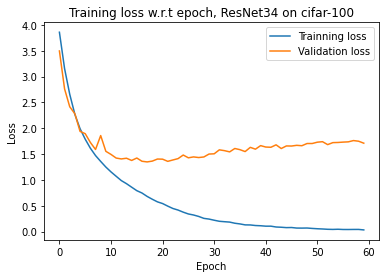

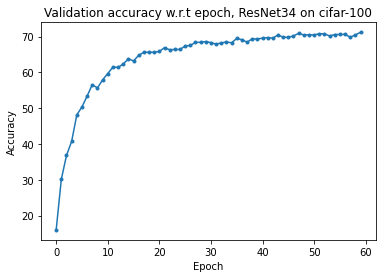

In [27]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, ResNet34 on cifar-100') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy w.r.t epoch, ResNet34 on cifar-100') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')